In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import os
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Preferencias Grade')

m = pd.read_csv('resultados_simul_RT_2.csv')

m.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1298 non-null   int64  
 1   rhat        1298 non-null   float64
 2   dhat        1298 non-null   float64
 3   w           1298 non-null   float64
 4   prd         1298 non-null   float64
 5   pdesp       1298 non-null   float64
 6   SD          1298 non-null   float64
 7   CTS         1298 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 81.2 KB


# Análisis de resultados de simulaciones de seguro de desempleo y CTS

* Para ambos, el seguro de desempleo y el CTS, corrimos 90 simulaciones de 60 periodos cada una. (Cada periodo representa un mes de vida.)


* Para comparar el beneficio que brinda cada política nos basamos en el promedio de la utilidad de cada sujeto en cada simulación bajo ambos sistemas.

> Explotamos la estructura de dependencia en los datos (contamos observaciones del mismo sujeto bajo SD y CTS) para controlar por características de cada sujeto.

# Distribucion de utilidad Simulada Seguro Desempleo

$U_{SD}$

Utilidad censurada en 12000 utiles

count                                       1298.000
mean        807814593475864050391830473337733120.000
std       28788189821245389605009150727440826368.000
min                                           12.449
25%                                          183.429
50%                                          682.768
75%                                         6847.754
max     1037126234882634059820926275594978590720.000
Name: SD, dtype: float64


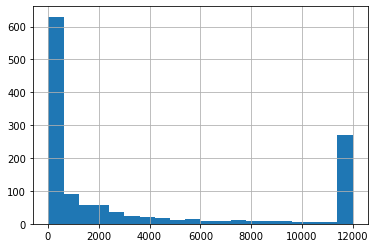

In [2]:
print(m['SD'].describe())
m['SD'].clip(np.nan, 12000).hist(bins=20);

# Distribucion de  Utilidad Simulada CTS

$U_{CTS}$


count                                      1298.000
mean       467424975132829435068857199307522048.000
std      16660977947204251617872563148611911680.000
min                                          18.111
25%                                         183.530
50%                                         679.280
75%                                        6734.187
max     600231368627510447286746238500145725440.000
Name: CTS, dtype: float64


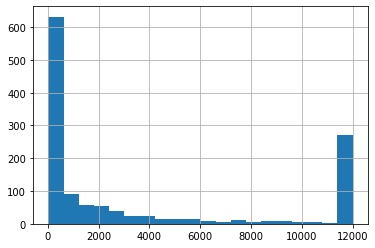

In [3]:
print(m['CTS'].describe())
m['CTS'].clip(np.nan, 12000).hist(bins=20);

# La diferencia por persona

$U_{SD} - U_{CTS}$

In [4]:
m['dif'] = m['SD'] - m['CTS']
m['dif'].describe()

count                                      1298.000
mean       340389618343034615322973274030211072.000
std      12127212882062680440384017121809530880.000
min                        -9258312416543039488.000
25%                                          -0.154
50%                                           0.186
75%                                          27.031
max     436894866255123612534180037094832865280.000
Name: dif, dtype: float64

Censurada en -5000 y 5000 utiles

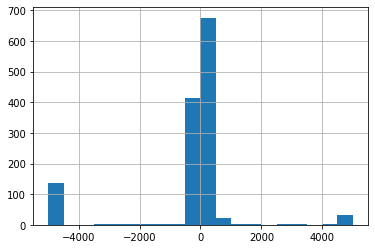

In [5]:
m['dif'].clip(-5000, 5000).hist(bins=20);

# Comparación de distribuciones: tests estadísticos

##Comparaciones con toda la muestra: 

*   los tests no paramétricos rechazan holgadamente la hipótesis nula que la mediana de la diferencia de utilidades es 0.

*   El t-test no puede rechazar la hipótesis nula.


In [6]:
from scipy.stats import wilcoxon, ttest_rel, binom_test

# Paired t-test
s, pv = ttest_rel(m['SD'], m['CTS'])

print(f'Media utilidad de SD: {m.SD.mean()}.', f'Media utilidad de CTS: {m.CTS.mean()}.',
      f'T-statistic: {s}.', f'P-val: {pv}.', sep = '\n', end = '\n\n')

# Wilcoxon
d = m['SD'] - m['CTS']
w, p = wilcoxon(d)
print(f'Media de diferencia utilidad: {np.mean(d)}.', f'Mediana de diferencia utilidad {np.median(d)}.', \
      f'Wilcoxon statistic: {w}.', f'P-val: {p}.', sep = '\n', end = '\n\n')

#sign test
mayor = m[m['dif'] > 0]['dif'].size
todos = m['dif'].size
g = binom_test(mayor, todos, p=0.5)
print(f'Sign test p-val: {g}.', f'Con {mayor} sujetos con u_sd > u_cts del total de {todos}.', 
      sep = '\n', end = '\n\n')



Media utilidad de SD: 8.07814593475864e+35.
Media utilidad de CTS: 4.674249751328294e+35.
T-statistic: 1.0112362998600255.
P-val: 0.3120919553937859.

Media de diferencia utilidad: 3.403896183430346e+35.
Mediana de diferencia utilidad 0.18578667562063345.
Wilcoxon statistic: 297338.0.
P-val: 3.784159693586539e-20.

Sign test p-val: 6.491251354640002e-07.
Con 739 sujetos con u_sd > u_cts del total de 1298.



## Comparaciones por grupos:

Usamos las diferencias en los parámetros de preferencias individuales para explicar los cambios de utilidad entre el seguro de desempleo y el CTS


### T-Test

Con este test paramétrico encontramos diferencias estadisticamente significativas para dos grupos interesantes: 

1.   los moderadamente aversos al riesgo e impacientes (N=327)
2.   Los muy aversos al riesgo y relativamente pacientes (N=102)

> Ambas diferencias son a favor del seguro de desempleo.


In [7]:
pd.reset_option('^display.', silent=True)

m['riesgo'] = pd.cut(m.rhat,bins=[-20, 0, 1,20],labels=['AmanteRiesgo','Moderado','MuyAverso'])
m['tiempo'] = pd.cut(m.dhat,bins=[-20, 0, 1,20],labels=['Loco','Paciente','Impaciente'])    

c = m[['dif', 'riesgo', 'tiempo' ]].groupby(by=['riesgo', 'tiempo']).size()
a = m[['SD', 'CTS', 'dif', 'riesgo', 'tiempo' ]].groupby(by=['riesgo', 'tiempo']).mean()

tstats, pvals = [], []
wstats, pwvals = [], []
svals = []

for riesgo in ('AmanteRiesgo', 'Moderado', 'MuyAverso'):
  for tiempo in ['Loco', 'Paciente', 'Impaciente']:
    
    t = m[(m['riesgo'] == riesgo) & (m['tiempo'] == tiempo)]

    #t-test
    s, pv = ttest_rel(t['SD'] , t['CTS'])
    tstats.append(s)
    pvals.append(pv)

    #wilcoxon
    w, p = wilcoxon(t['SD'] , t['CTS'])
    wstats.append(w)
    pwvals.append(p)    

    #sign test
    g = binom_test(t[t['dif'] > 0]['dif'].size, t['dif'].size, p=0.5)
    svals.append(g) 

def stars(pval):
  if pval < .001: return 3*'*'
  elif pval < .01: return 2*'*'
  elif pval < .05: return '*'
  else: return ''

s = [stars(pval) for pval in pvals]
p = [round(pv, 3) for pv in pvals]

arrays = [["AmanteRiesgo", "AmanteRiesgo", "AmanteRiesgo", "Moderado", "Moderado", "Moderado", 'MuyAverso', 'MuyAverso', 'MuyAverso'],
          ['Loco','Paciente','Impaciente', 'Loco','Paciente','Impaciente', 'Loco','Paciente','Impaciente']]

tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=["riesgo", "tiempo"])

s = pd.Series(s, index=index, name="")
p = pd.Series(p, index=index, name='t-test p-val')

r = pd.concat([c, a, p, s], axis = 1)
r.rename(columns={0: "N", ('dif', 'mean'): "dif. media", ('dif', 'median'): 'dif. mediana'}, inplace=True)
r

N            SD  ...  t-test p-val     
riesgo       tiempo                         ...                   
AmanteRiesgo Loco         17  6.167902e+37  ...         0.327     
             Paciente     32  5.350960e+16  ...         0.248     
             Impaciente  101  2.929477e+15  ...         0.084     
Moderado     Loco         12  1.487592e+21  ...         0.337     
             Paciente    119  3.763644e+04  ...         0.009   **
             Impaciente  327  1.075933e+04  ...         0.000  ***
MuyAverso    Loco         20  1.589081e+26  ...         0.330     
             Paciente    102  4.653362e+02  ...         0.003   **
             Impaciente  568  2.307997e+02  ...         0.972     

[9 rows x 6 columns]

Si tasa_descuento < 0 (Loco) o r < 0 (amante al riesgo) la utilidad explota

## Otros tests: Wilcoxon y sign

En general, los tests no parámetricos encuentran diferencias muy significativas en casi todas las agrupaciones. Sin embargo, algunas son en la dirección opuesta al ttest.

* Es notable que ambos test concuerdan que los grupos de _amantes al riesgo pacientes_ y _amantes al riesgo impacientes_ fueron favorecidos por el CTS sobre el SD.

* También encontramos una diferencia significativa, pero en la dirección contraria que el ttestm en el grupo _muy averso al riesgo y paciente_

In [8]:
a = m[['dif', 'riesgo', 'tiempo' ]].groupby(by=['riesgo', 'tiempo']).median()

sw = [stars(pval) for pval in pwvals]
sg = [stars(pval) for pval in svals]
pw = [round(pw, 3) for pw in pwvals]
g = [round(g, 3) for g in svals]

sw = pd.Series(sw, index=index, name="")
sg = pd.Series(sg, index=index, name="")
pw = pd.Series(pw, index=index, name='wilcoxon p-val')
g = pd.Series(g, index=index, name='sign-test p-val')

r = pd.concat([c, a, pw, sw, g,sg], axis = 1)
r.rename(columns={0: "N", 'dif': 'dif. mediana'}, inplace = True)
r

N  dif. mediana  ...  sign-test p-val     
riesgo       tiempo                         ...                      
AmanteRiesgo Loco         17  3.172467e+20  ...            0.629     
             Paciente     32 -9.464518e+09  ...            0.000  ***
             Impaciente  101 -4.517862e+12  ...            0.000  ***
Moderado     Loco         12  2.688243e+11  ...            0.006   **
             Paciente    119  8.181641e+01  ...            0.000  ***
             Impaciente  327  3.556098e+01  ...            0.000  ***
MuyAverso    Loco         20  9.182582e+00  ...            0.263     
             Paciente    102 -3.608370e-02  ...            0.004   **
             Impaciente  568 -2.953456e-02  ...            0.000  ***

[9 rows x 6 columns]

In [9]:
m[['rhat', 'dhat' ]].corr(method='pearson')

,rhat,dhat
rhat,1.000000,0.043541
dhat,0.043541,1.000000


## Regresión

$U_{SD} - U_{CTS} = riesgo + tiempo + probDespido + ingreso + error$ 


dónde, 


\begin{equation}
  U_{SD} - U_{CTS} = \left \{
  \begin{aligned}
    &1, && \text{si}\ U_{SD} > U_{CTS} \\
    &0, && \text{de lo contrario}
  \end{aligned} \right.
\end{equation} 

In [13]:
import statsmodels.api as sm
from patsy import dmatrices

exp = pd.get_dummies(m, columns=['riesgo', 'tiempo'])

exp['o'] = np.where(d > 0, 1, 0)

print(exp['o'].sum())

reg  = "o ~ rhat + dhat + prd + w"
reg1  = "o ~ rhat + dhat + I(rhat**2) + I(dhat**2) + pdesp + w" 
reg2 = "o ~ riesgo_AmanteRiesgo + riesgo_Moderado + tiempo_Loco + tiempo_Paciente + pdesp + w"
reg3 = "o ~ riesgo_AmanteRiesgo:tiempo_Loco + riesgo_AmanteRiesgo + tiempo_Loco + pdesp + w"

regresiones = [reg, reg1, reg2, reg3]

for i, r in enumerate(regresiones):
  outcome, predictors = dmatrices(r, exp)  
  mod = sm.Probit(outcome, predictors)
  res = mod.fit(cov_type='hc0')
  print(f'regresión {i}')
  print('\n')
  print(r)
  print('\n')
  print(res.summary())
  print('\n\n\n\n')

739
Optimization terminated successfully.
         Current function value: 0.645307
         Iterations 5
regresión 0


o ~ rhat + dhat + prd + w


                          Probit Regression Results                           
Dep. Variable:                      o   No. Observations:                 1298
Model:                         Probit   Df Residuals:                     1293
Method:                           MLE   Df Model:                            4
Date:                Fri, 03 Dec 2021   Pseudo R-squ.:                 0.05588
Time:                        13:59:36   Log-Likelihood:                -837.61
converged:                       True   LL-Null:                       -887.18
Covariance Type:                  hc0   LLR p-value:                 1.492e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8214      0.121      6.767      0.000       0